In [1]:
import game

from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import numpy as np

import agent

In [2]:
def visualize(stateHistory, actionHistory, rewardHistory, N):
    inventory = stateHistory[:, 0, :]
    orders = actionHistory[:, 1, :]
    serviceTimes = actionHistory[:, 0, :]
    reorderPoints = stateHistory[:, 1, :]
    
    print("Time Series")
    for i in range(2, -1, -1):
        plt.figure(figsize=(20, 4))
        
        alpha = 1 if i == 2 else 0.3
#         plt.step(range(N+1), inventory[:, i] * np.roll(np.sign(orders[:, i]), -1), label="inventory")        
        plt.plot(range(N+1), inventory[:, i], label="inventory", alpha=alpha, c='b', linestyle='--', drawstyle='steps')
        plt.step(range(N+1), orders[:, i], label="order quantity", c='orange')
        if i == 2:
            plt.step(range(N+1), reorderPoints[:, i], label="reorder point", c='green')
        plt.ylim((-5, 30))
        plt.legend()
    plt.show()

    print("Service Time")
    for i in range(2, -1, -1):
        plt.figure(figsize=(20, 4))
        plt.step(range(N+1), serviceTimes[:, i], label="service time")
        plt.ylim((-5, 30))
        plt.legend()
    plt.show()

    
    print("Inventory")
    for i in range(2, -1, -1):
        plt.figure(figsize=(20, 4))
        plt.step(range(N+1), inventory[:, i] * np.sign(orders[:, i]), label="inventory")
        plt.ylim((-5, 30))
        plt.legend()
    plt.show()

    print("Rewards")
    plt.figure(figsize=(20, 4))
    plt.step(range(N+1), rewardHistory)
    plt.show()

In [3]:
learningParams = {
    "gamma": 0.2,
    "alpha": 1,
    "epsilon": 0.5
}

envParams = {
    "inventoryCost": [5, 1000, 1000], #[1000, 5, 1000], #
    "muDemand": 2,
    "stdDemand": 0, #0.1, #1,
    "retailerOrder": 10,
    "stockoutCost": 10000,
    "N": 1000
}

In [4]:
plannerAgent = agent.PlannerWithPolicyGradient(learningParams, envParams["retailerOrder"])
plannerAgent.policy_estimator.stdVal = 5

Time Series


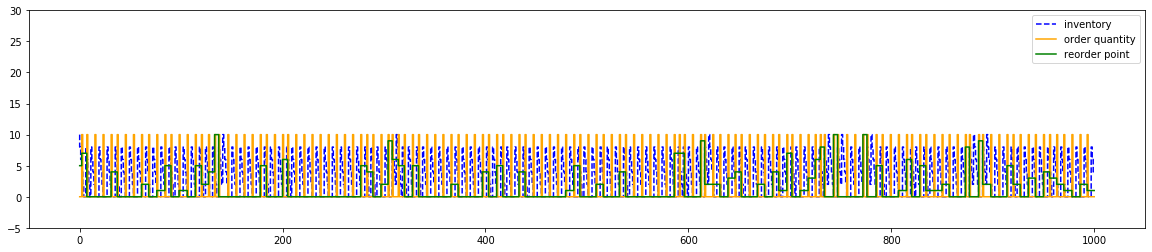

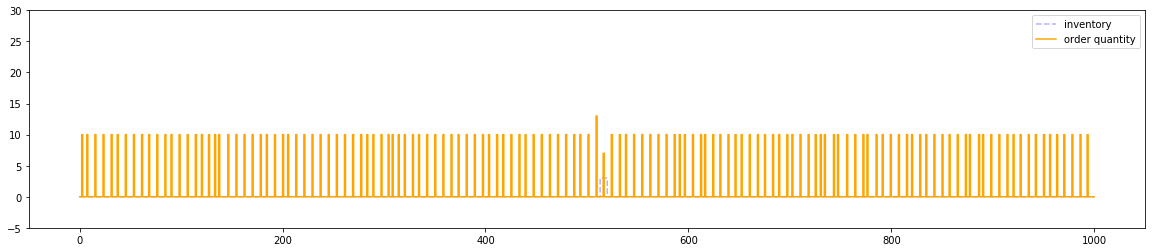

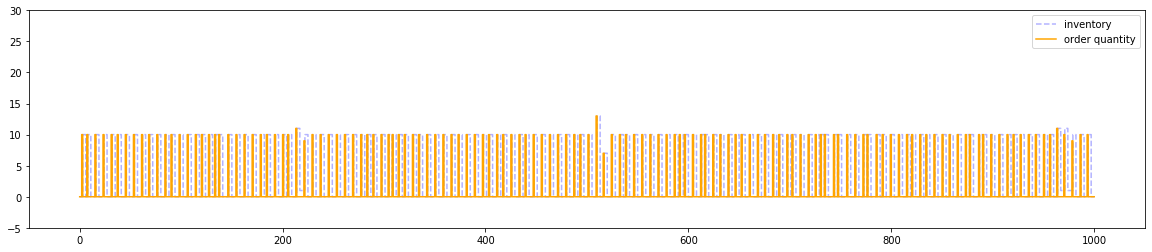

Service Time


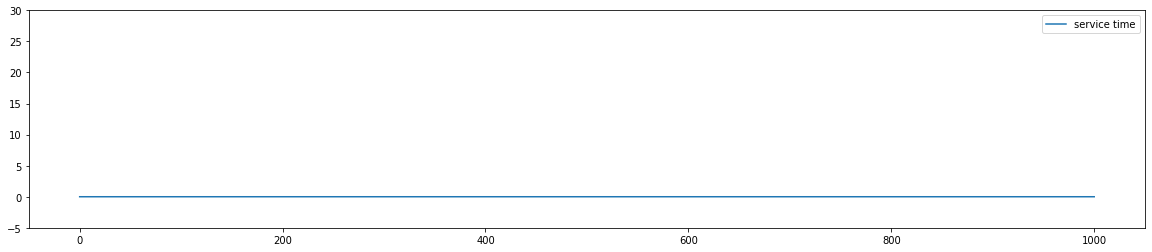

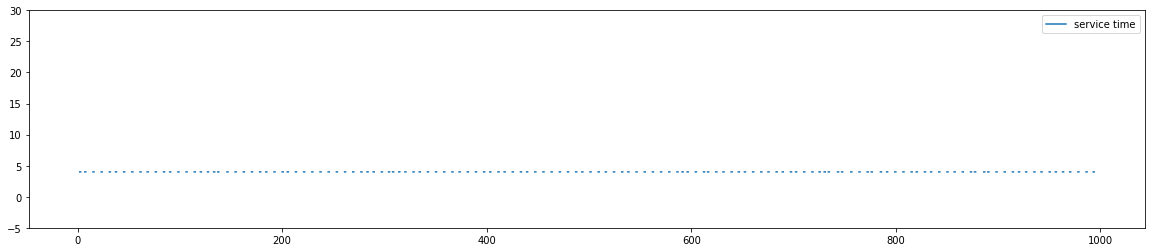

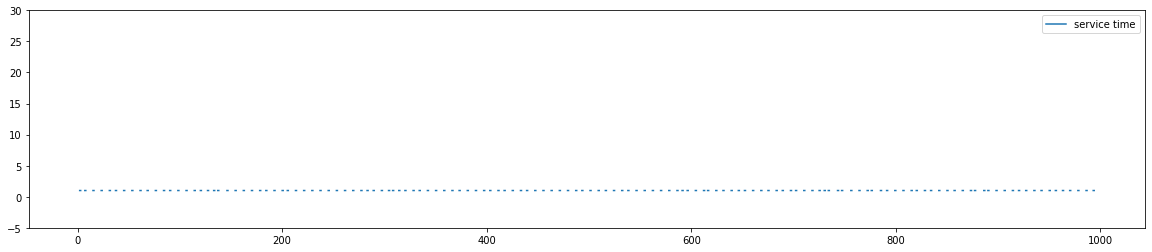

Inventory


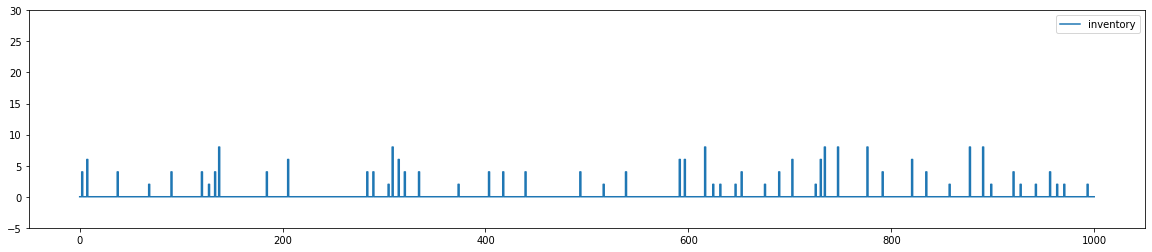

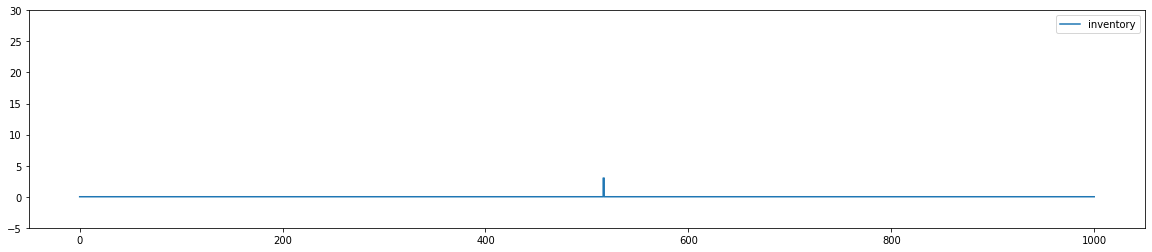

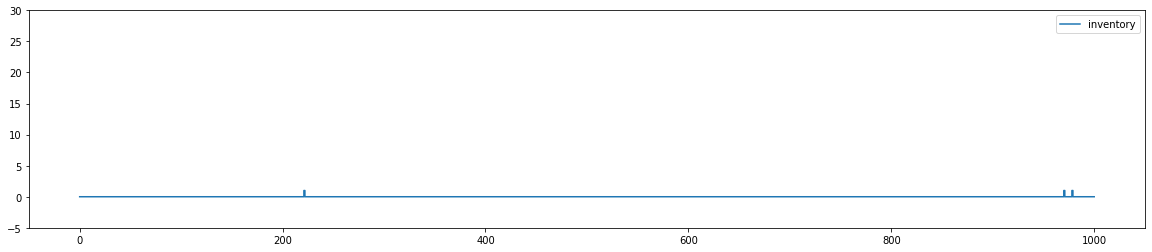

Rewards


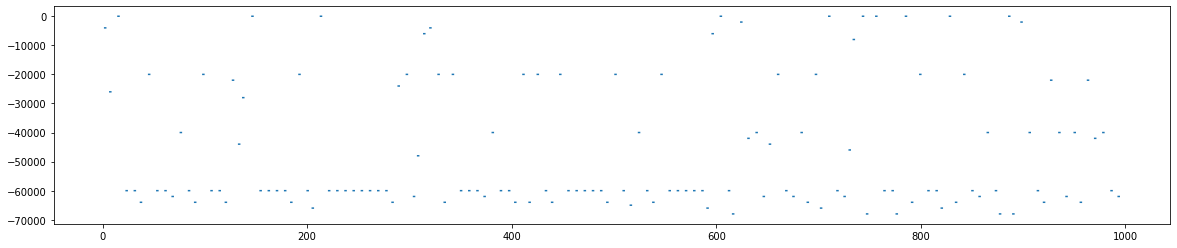

In [5]:
# play the game while training
stateHistory, actionHistory, rewardHistory, experiences = game.runEpisode(envParams, plannerAgent, train=False)

visualize(stateHistory, actionHistory, rewardHistory, envParams["N"])


-19377.883
(array([4.935321 , 4.952238 , 1.7975401], dtype=float32), array([10., 10., 10.], dtype=float32))


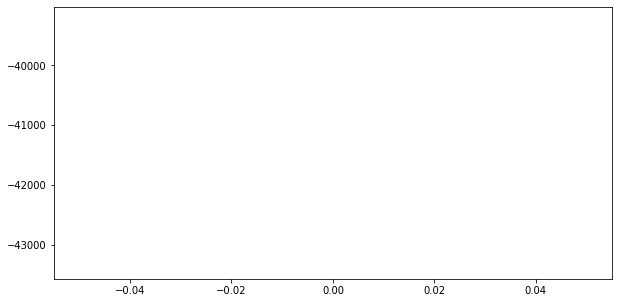

-53725.305
(array([16.324238, 16.386566,  4.100762], dtype=float32), array([21., 15., 10.], dtype=float32))


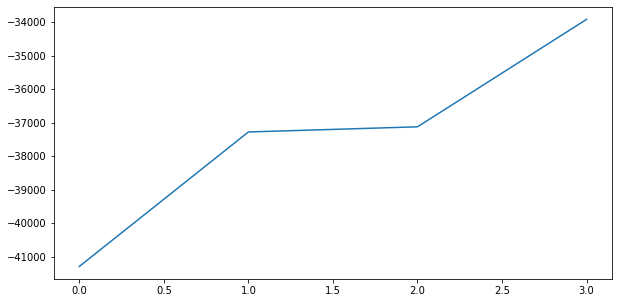

-72980.09
(array([15.882058 , 12.331634 ,  5.9786315], dtype=float32), array([17., 17.,  0.], dtype=float32))


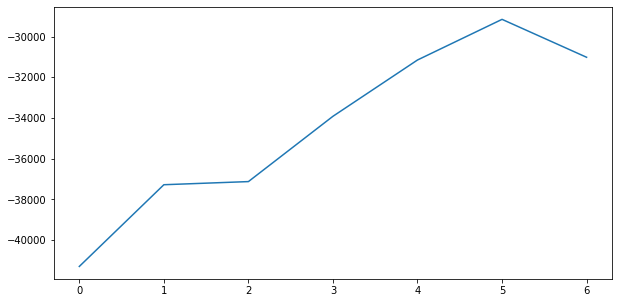

-86070.914
(array([16.866808, 13.021108,  6.491734], dtype=float32), array([16., 10.,  0.], dtype=float32))


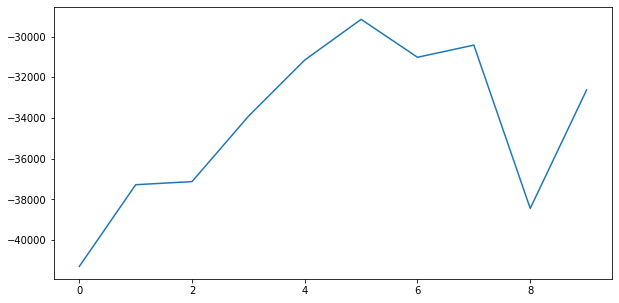

-81920.586
(array([19.1476   , 13.9590025,  7.530877 ], dtype=float32), array([22., 14.,  2.], dtype=float32))


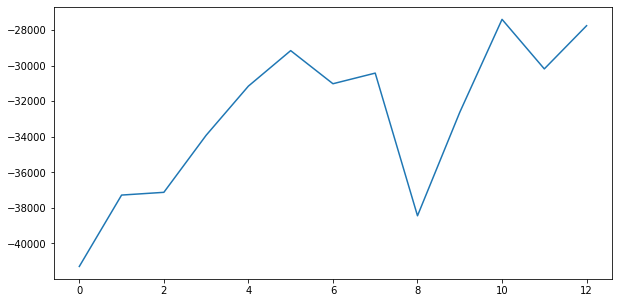

-78525.484
(array([18.161184, 16.487534, 10.341701], dtype=float32), array([15., 15., 10.], dtype=float32))


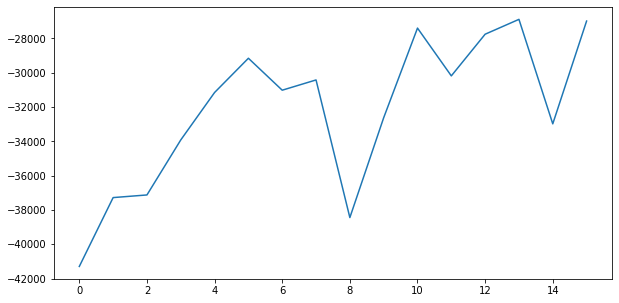

-104991.945
(array([31.503036, 17.461655,  9.143735], dtype=float32), array([30., 15.,  9.], dtype=float32))


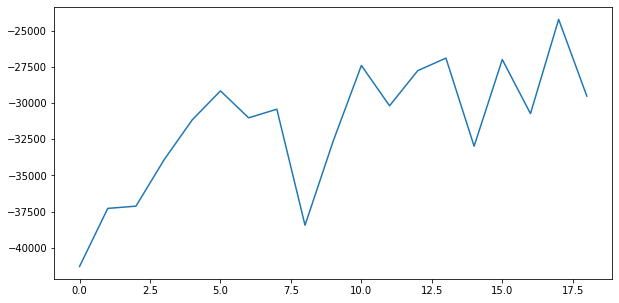

-72207.21
(array([31.722305, 13.703214,  8.556176], dtype=float32), array([26., 10., 10.], dtype=float32))


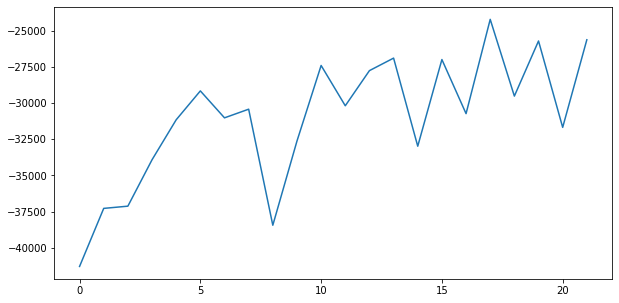

-65598.35
(array([14.11183 , 10.893914,  5.998649], dtype=float32), array([16., 10.,  8.], dtype=float32))


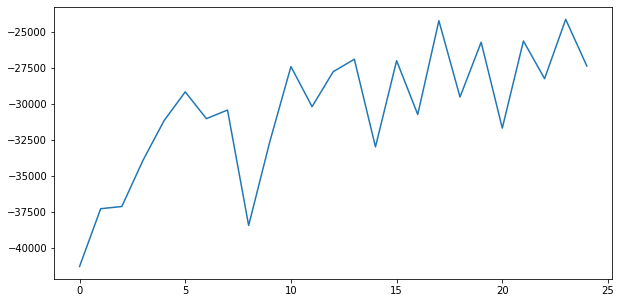

-91401.82
(array([23.256195 , 12.357836 ,  7.2731543], dtype=float32), array([25., 18.,  9.], dtype=float32))


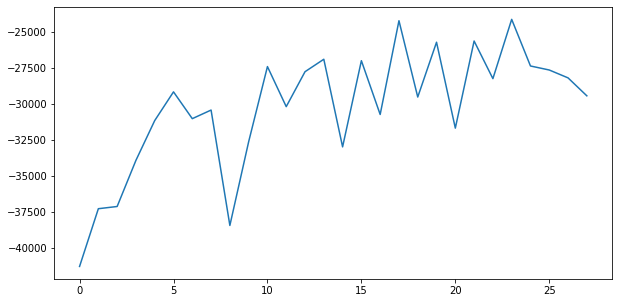

-58567.26
(array([11.014833, 10.477162,  5.150085], dtype=float32), array([14., 11.,  7.], dtype=float32))


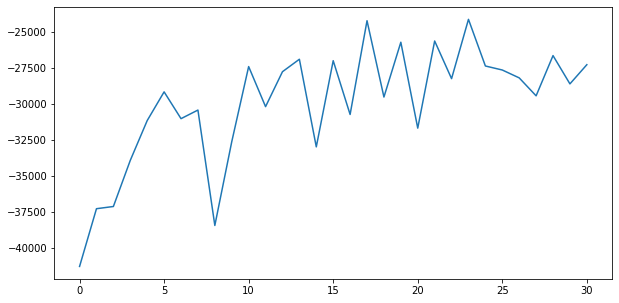

-70053.68
(array([15.876899 , 11.047188 ,  5.1560874], dtype=float32), array([20., 20.,  3.], dtype=float32))


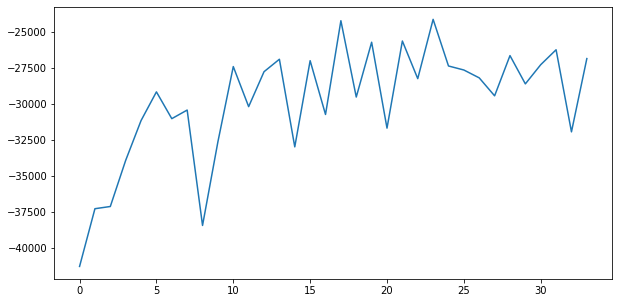

-56007.188
(array([13.686252,  9.925232,  4.815086], dtype=float32), array([10., 10.,  3.], dtype=float32))


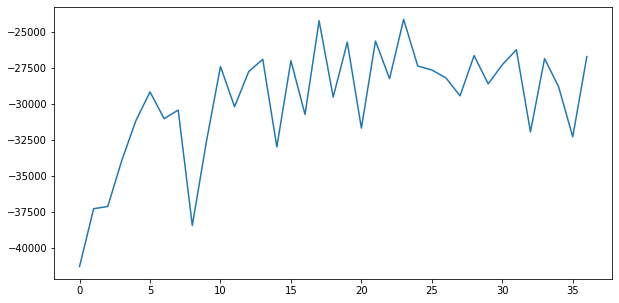

-64164.875
(array([19.274878, 12.082828,  6.531785], dtype=float32), array([16., 16.,  5.], dtype=float32))


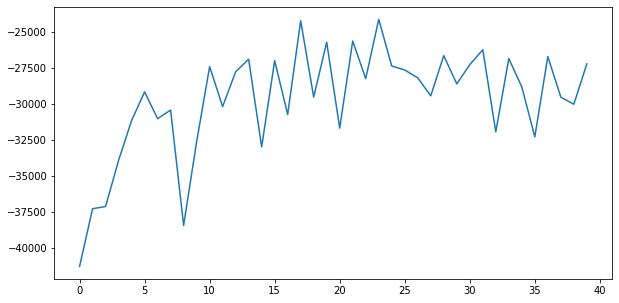

-65957.65
(array([14.382389, 12.931087,  5.002047], dtype=float32), array([12., 12.,  0.], dtype=float32))


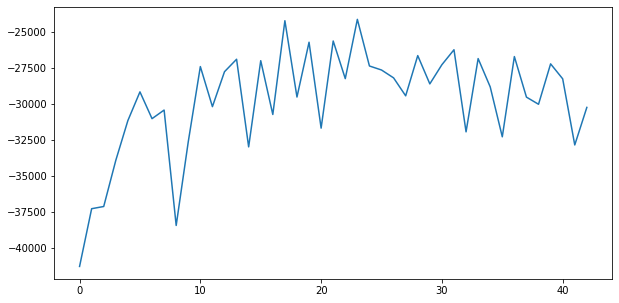

-85670.81
(array([16.163248, 13.684374,  7.232716], dtype=float32), array([19., 12., 10.], dtype=float32))


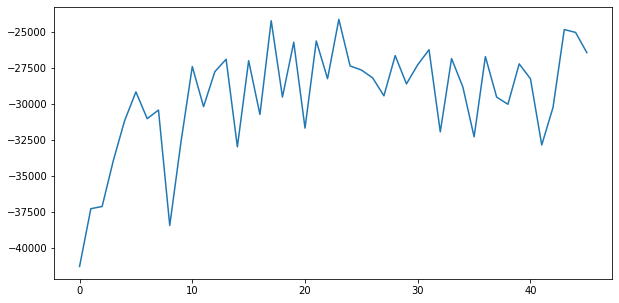

-52132.1
(array([28.249239 , 15.286896 ,  4.7412896], dtype=float32), array([19., 15.,  0.], dtype=float32))


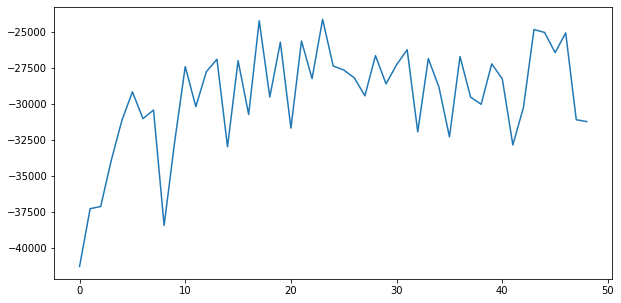

In [6]:
rewardsAll = []
experienceAll = []
for i in tqdm_notebook(range(50)):
# play the game while trainings
    _, _, rewards, experiences = game.runEpisode(envParams, plannerAgent, train=True)
    averageRewards = np.nansum(rewards)/np.count_nonzero(~np.isnan(rewards))
    rewardsAll.append(averageRewards)
    experienceAll.extend(experiences)

    if (i % 3 == 0): # & (i > 0):
        print(plannerAgent.value_estimator.predict(np.array([0, 0, 0])))
        print(plannerAgent.policy_estimator.predict(np.array([0, 0, 0]), capacity=[30, 30, 30], retailerOrderQty=10))
        plt.figure(figsize=(10, 5))
        plt.plot(rewardsAll)
        plt.show()

In [7]:
print(plannerAgent.value_estimator.predict(np.array([0, 0, 0])))
print(plannerAgent.policy_estimator.predict(np.array([0, 0, 0]), capacity=[30, 30, 30], retailerOrderQty=10))


-71761.58
(array([20.290285 ,  8.7402   ,  3.6804445], dtype=float32), array([10., 10.,  0.], dtype=float32))


[5, 1000, 1000]
Time Series


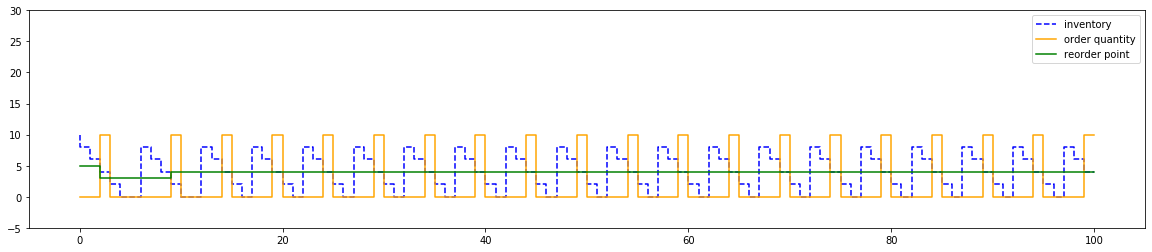

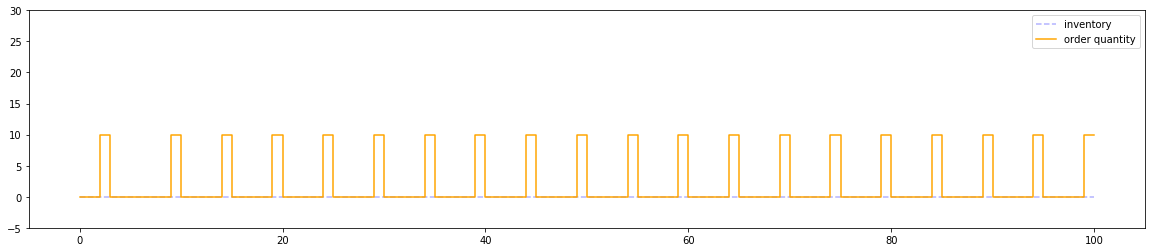

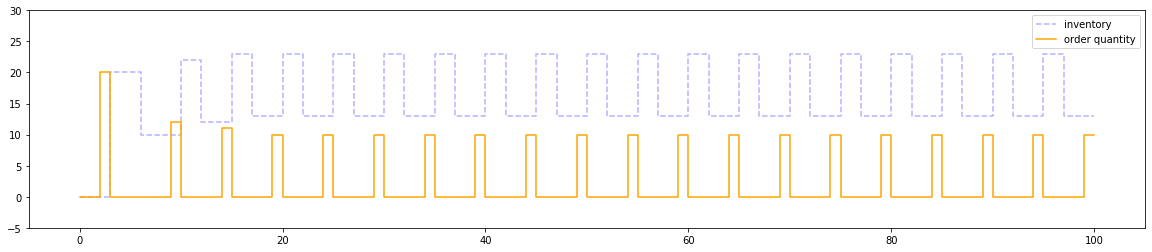

Service Time


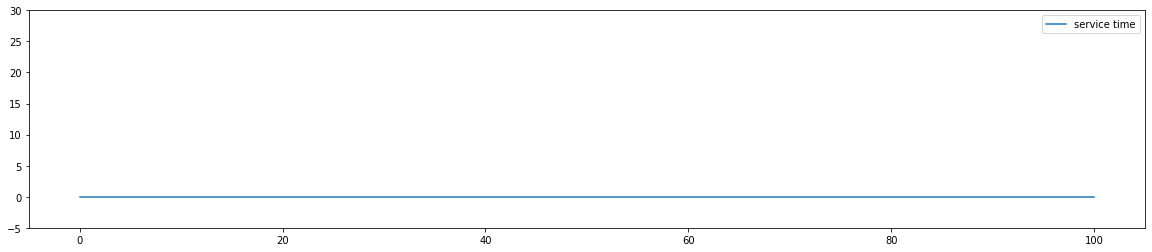

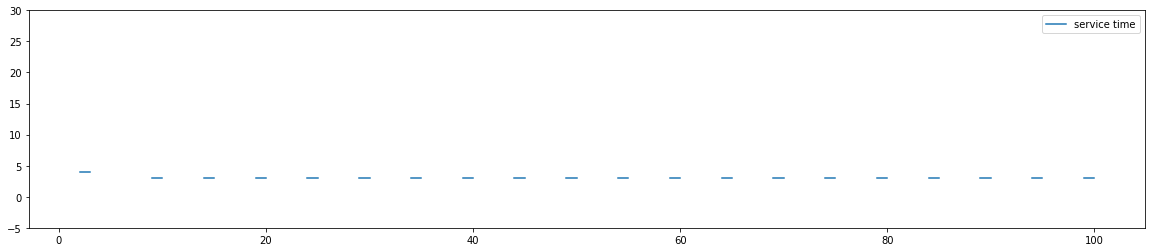

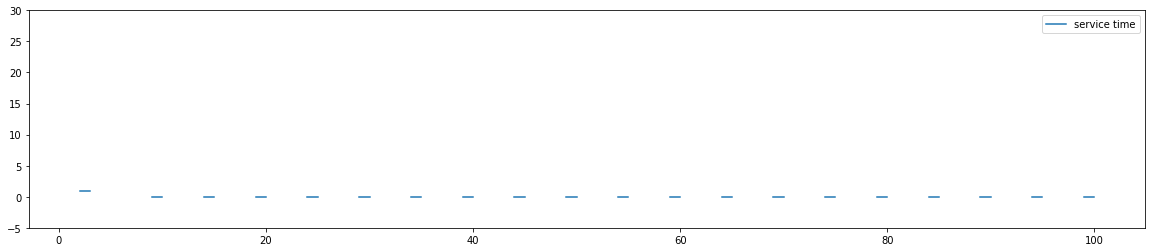

Inventory


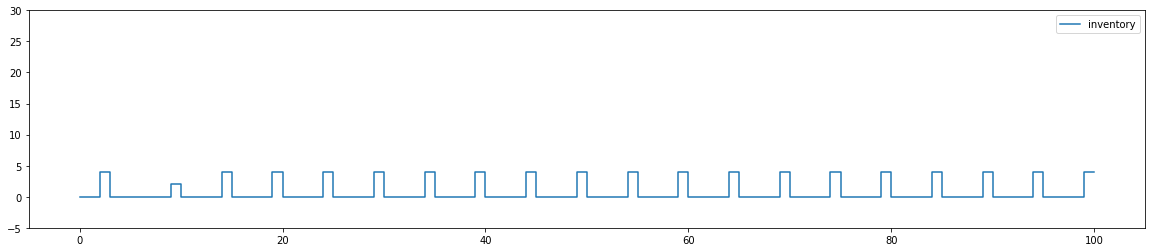

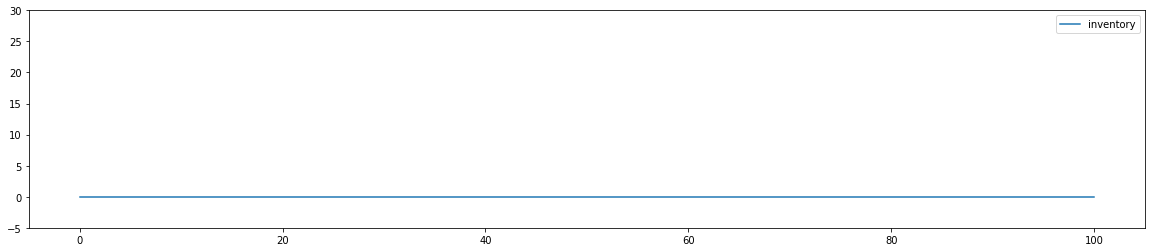

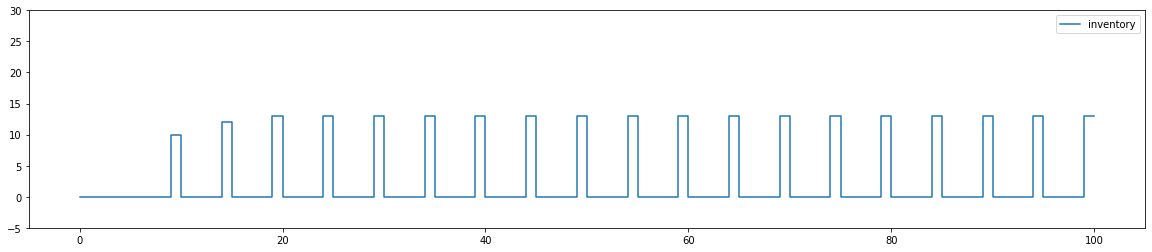

Rewards


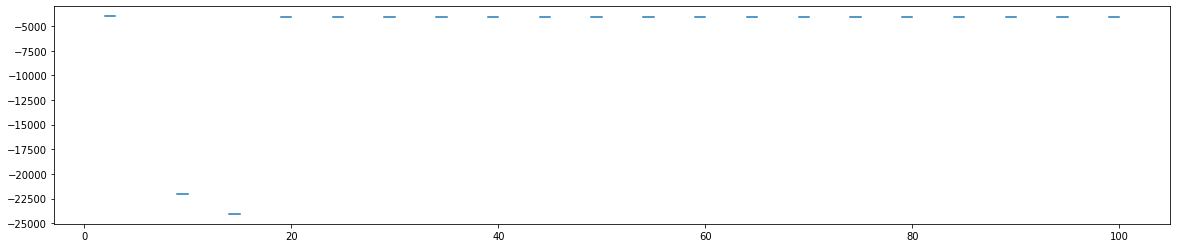

In [8]:
plannerAgent.policy_estimator.stdVal = 0
envParams["N"] = 100

print(envParams["inventoryCost"])
# play the game while training
stateHistory, actionHistory, rewardHistory, experiences = game.runEpisode(envParams, plannerAgent, train=False)

visualize(stateHistory, actionHistory, rewardHistory, envParams["N"])


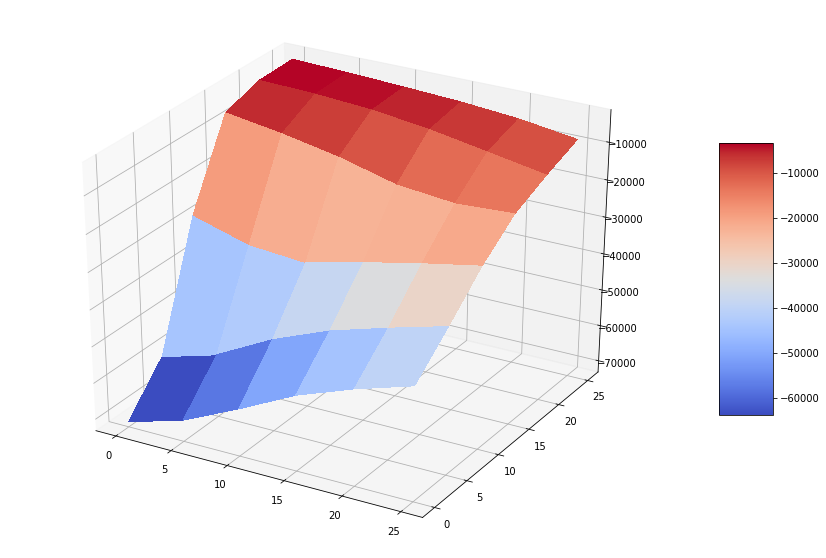

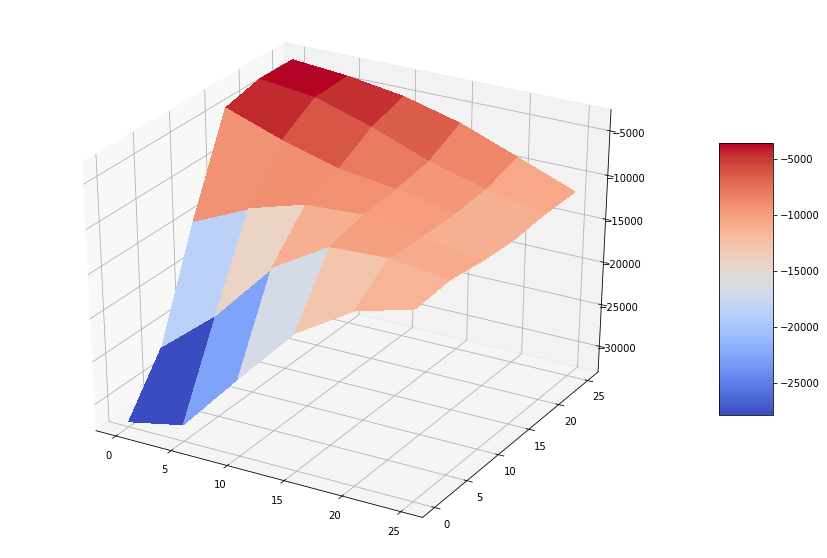

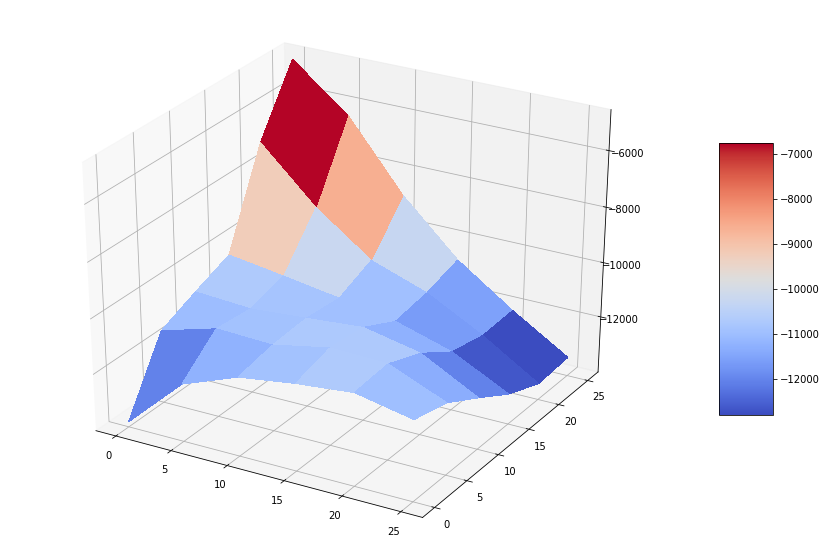

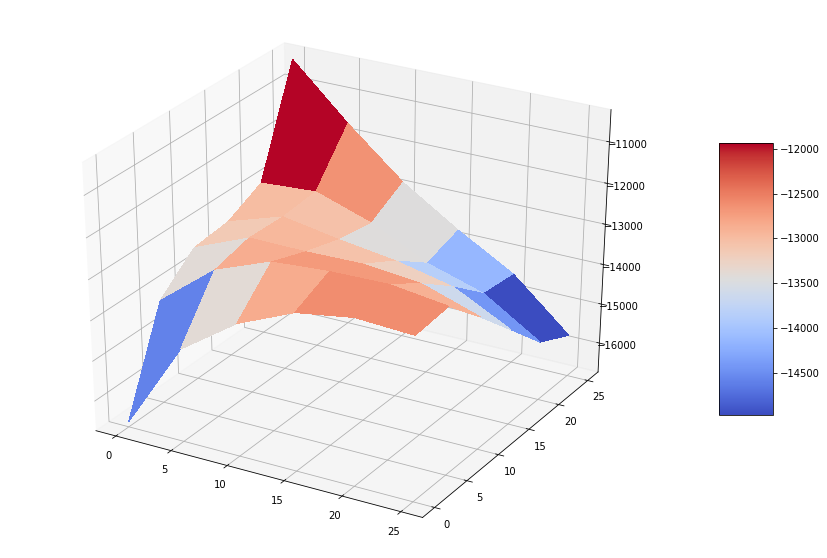

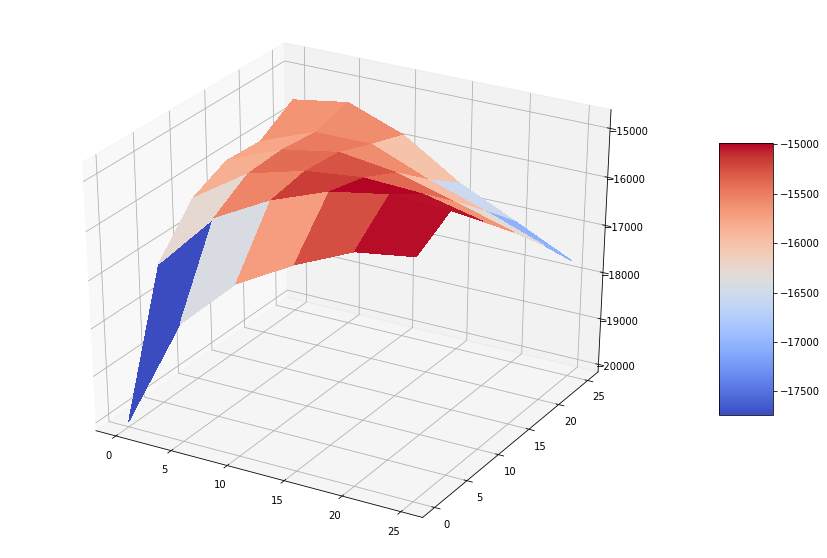

In [9]:
"""
Illustrate Value Network
proxy to objective function
"""
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib import cm


for w in range(0, 20, 4):
    fig = plt.figure(figsize=(15, 10))
    ax = fig.gca(projection='3d')
    # Make data.
    X = np.arange(0, 30, 5)
    Y = np.arange(0, 30, 5)
    X, Y = np.meshgrid(X, Y)

    Z = np.zeros(X.shape)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            s = np.array([X[i,j], Y[i,j], w])
            state = np.reshape(s, (1, 3))
            z = plannerAgent.value_estimator.predict(state)
            Z[i, j] = z

    # Plot the surface.
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
    # ax.set_zlim(-199.48181, -199.48180)
    # ax.view_init(30, 80)

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)

    plt.show()


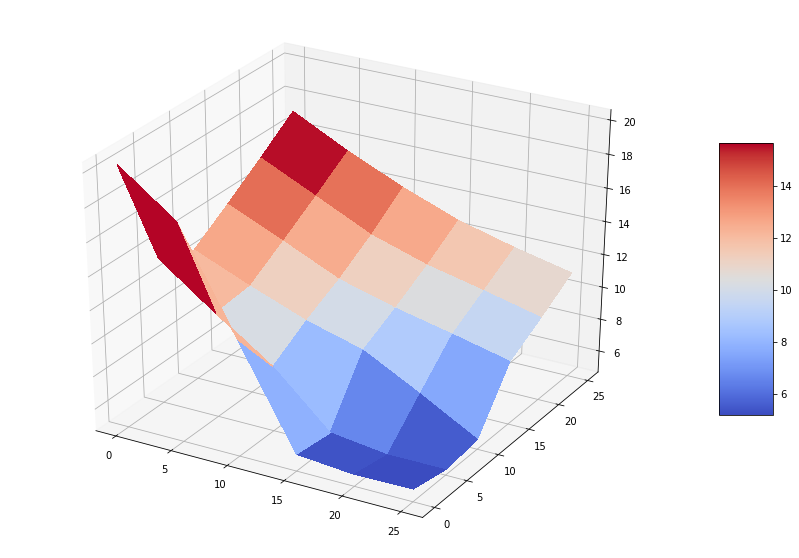

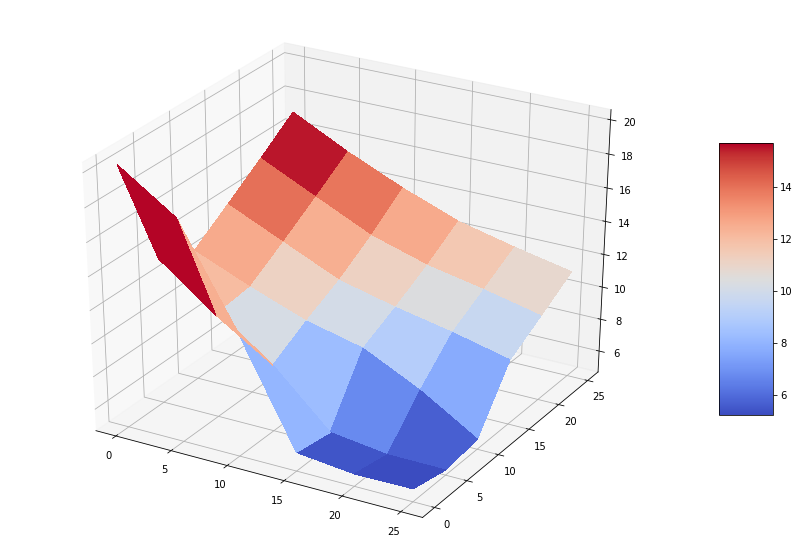

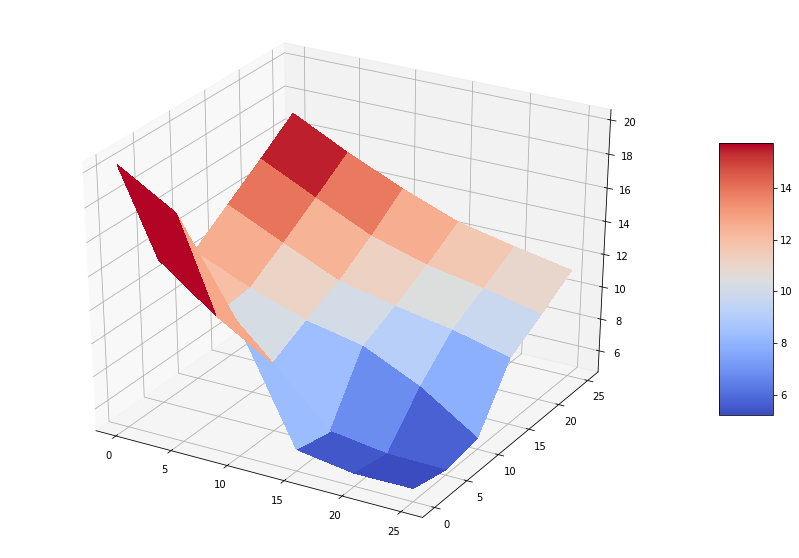

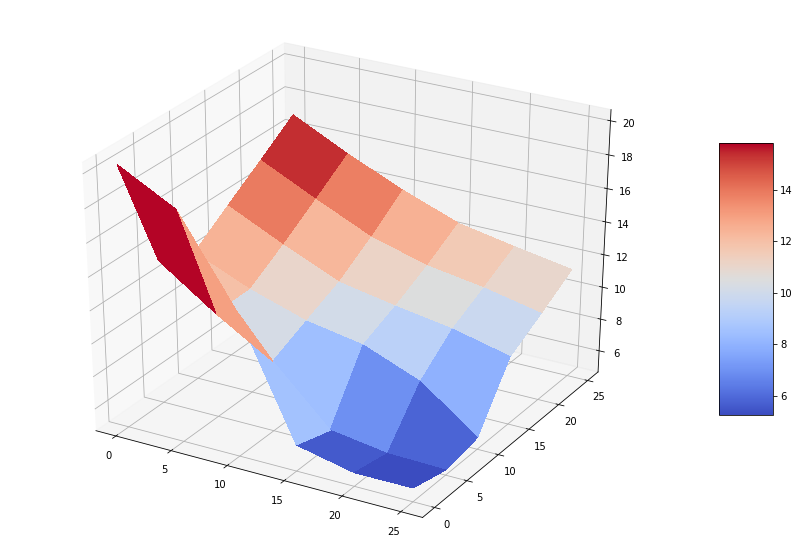

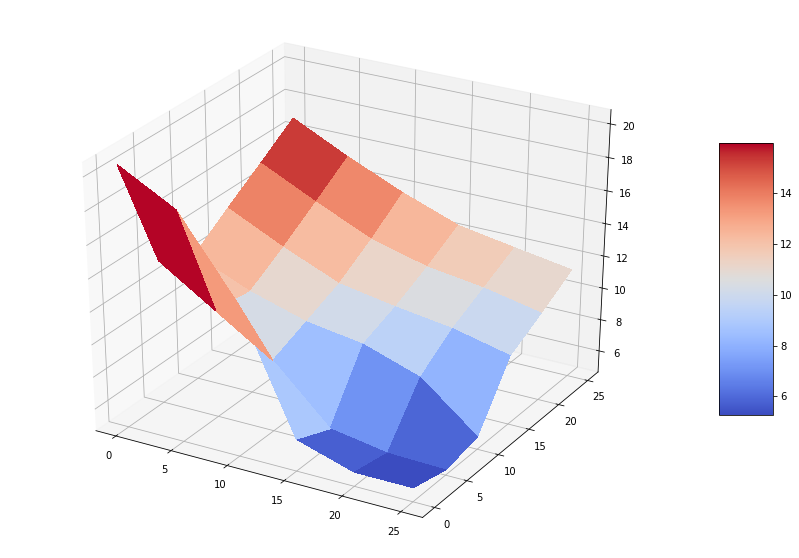

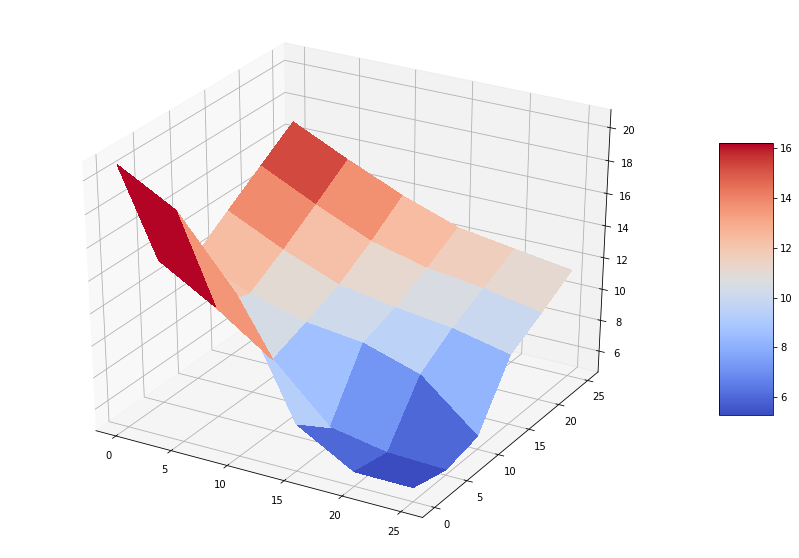

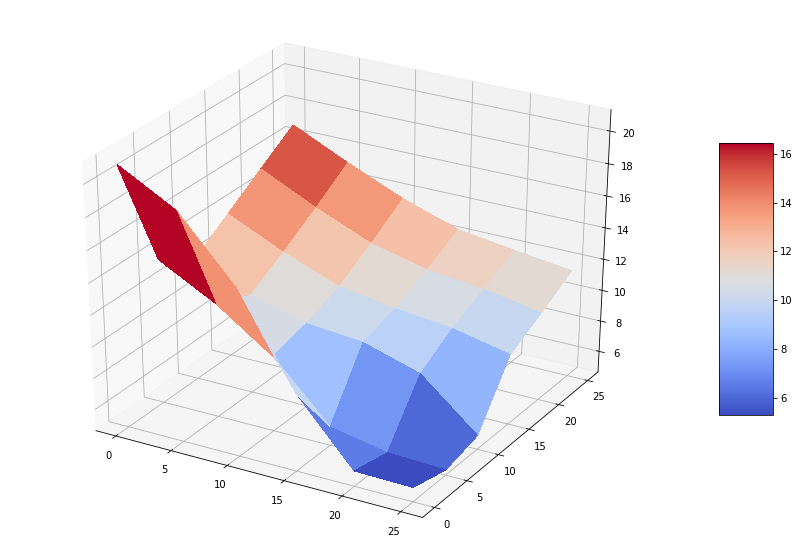

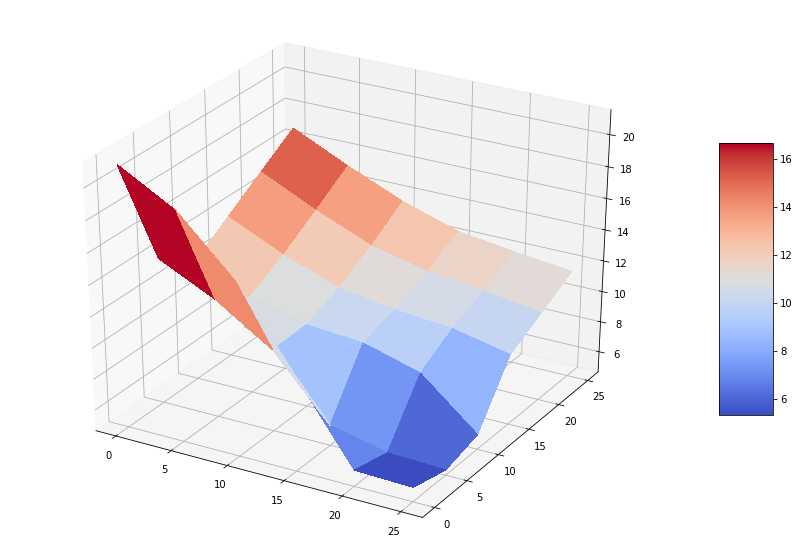

In [16]:
"""
Illustrate Policy Network
proxy to objective function
"""

from matplotlib import cm


for w in range(0, 8, 1):
    fig = plt.figure(figsize=(15, 10))
    ax = fig.gca(projection='3d')
    # Make data.
    X = np.arange(0, 30, 5)
    Y = np.arange(0, 30, 5)
    X, Y = np.meshgrid(X, Y)

    Z = np.zeros(X.shape)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            s = np.array([X[i,j], Y[i,j], w])
            state = s #np.reshape(s, (1, 3))
            mu, a = plannerAgent.policy_estimator.predict(state, capacity=[30, 30, 30], retailerOrderQty=10)
            z = mu[0]
            Z[i, j] = z

    # Plot the surface.
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
    # ax.set_zlim(-199.48181, -199.48180)
    # ax.view_init(30, 80)

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)

    plt.show()
